# test controller

maps/shared_room_map.mat
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      144
Number of nonzeros in inequality constraint Jacobian.:      141
Number of nonzeros in Lagrangian Hessian.............:      148

Total number of variables............................:       75
                     variables with only lower bounds:       11
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       44
Total number of inequality constraints...............:       64
        inequality constraints with only lower bounds:       33
   inequality constraints with lower and upper bounds:       31
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alp

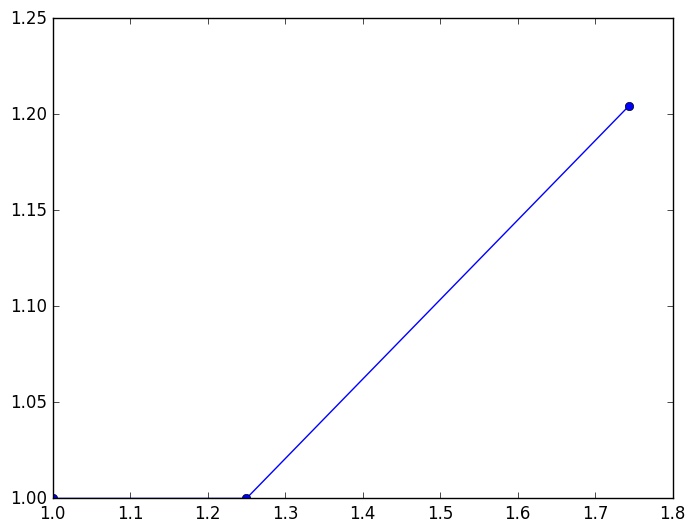

1.25,1.0,0.3926990841438454,1.0677333430008518]This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      144
Number of nonzeros in inequality constraint Jacobian.:      141
Number of nonzeros in Lagrangian Hessian.............:      148

Total number of variables............................:       75
                     variables with only lower bounds:       11
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       44
Total number of inequality constraints...............:       64
        inequality constraints with only lower bounds:       33
   inequality constraints with lower and upper bounds:       31
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(

In [3]:
# Test script for controller.jl without using the ROS part
push!(LOAD_PATH,pwd())
using CarMpcUtils
using CarMpc

### Simulation parameters
simLength = 2

# # initialize vehicle
robot = Robot([1.0, 1.0, 0.0, 0.5], model=unicycleDiscrete)

# # tuning parameters
# tuning = Tuning(dt = 0.2, dtMPC = 0.2, N = 20,
#                 Q = [0.5, 0.5, 10.0, 0.0], R = [20.0, 2.0],
#                 P = [1000.0, 20.0], vRef = 10.0, dSafe = 5.0,
#                 eYRef = 0.0, TTC = 3.0, eYSafe = 0.5)
# tuning = Tuning(dt = 1.0, dtMPC = 1.0, N = 2)
tuning = Tuning(dt = 0.5, N = 10, safe_dis = 1.0, safe_margin = 1.0, cmft_dis = 2.4)
# tuning = Tuning()

# map
# Map = TrackMap("maps/RFS_2Lanes_Speed_0128.mat")
field = Field("maps/shared_room_map.mat")

# ### Initialize MPC problem and solve dummy problem
mpc = initializeMPCProblem(robot, field, tuning)
nz, nu, N = mpc.nz, mpc.nu, tuning.N


# ################
# ##### Main #####
# ################

# ### MPC model parameters updated by subscribers
z0 = robot.z
u0 = zeros(nu)
z_h = zeros(4,N+1)

USim = zeros(nu,simLength)
ZSim = [z0 zeros(nz,simLength)]

### Main loop
for t=1:simLength
  ### Update and solve MPC problem
    ZOpt, UOpt, solveTime = updateSolveMpcProblem(mpc, z0, z_h)

  ### Update current input
  u0[1:nu] = UOpt[:,1]

  ### Update ego state
  # updateEgoState!(vehicle,u0,tuning.dtMPC)
  updateEgoState!(robot,u0,tuning.dt)

  ### Variables for logging
  ZSim[:,t+1] = robot.z
  USim[:,t] = u0
    print(robot.z)
end

using PyPlot
figure()
# plot(Map.nodes[1,:]',Map.nodes[2,:]')
plot(ZSim[1,:]',ZSim[2,:]',marker="o")
show()